In [86]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [87]:
df= pd.read_csv(r'C:\Users\yarde\Downloads\london_weather.csv')
df.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15341 non-null  int64  
 1   cloud_cover       15322 non-null  float64
 2   sunshine          15341 non-null  float64
 3   global_radiation  15322 non-null  float64
 4   max_temp          15335 non-null  float64
 5   mean_temp         15305 non-null  float64
 6   min_temp          15339 non-null  float64
 7   precipitation     15335 non-null  float64
 8   pressure          15337 non-null  float64
 9   snow_depth        13900 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.2 MB


***EDA***

In [89]:
df['date']= pd.to_datetime(df['date'], format='%Y%m%d')
df['year']= df['date'].dt.year
df['month']= df['date'].dt.month

In [90]:
#check missing values
df.isna().sum()

date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
year                   0
month                  0
dtype: int64

<Axes: xlabel='year', ylabel='mean_temp'>

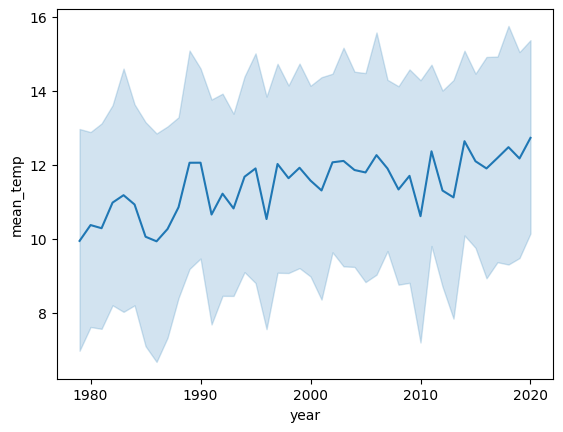

In [91]:
#as_index to not put the groupby in the index
df_per_month = df.groupby(['year','month'], as_index=False).mean()

sns.lineplot(x='year', y='mean_temp', data=df_per_month)

C:\Users\yarde\AppData\Local\Temp\ipykernel_15528\1501898183.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='month', y='sunshine', data=df_per_month, palette="hls")


<Axes: xlabel='month', ylabel='sunshine'>

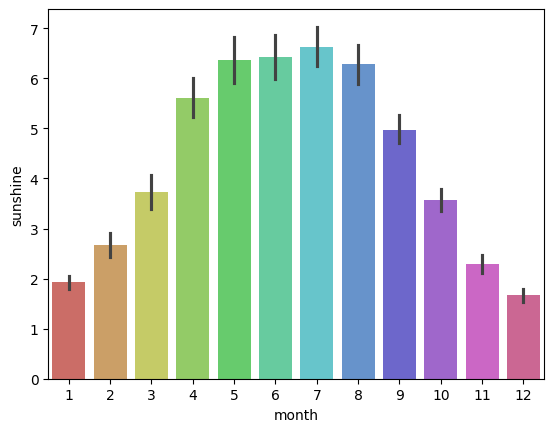

In [92]:
# color palette: https://seaborn.pydata.org/tutorial/color_palettes.html
sns.barplot(x='month', y='sunshine', data=df_per_month, palette="hls")

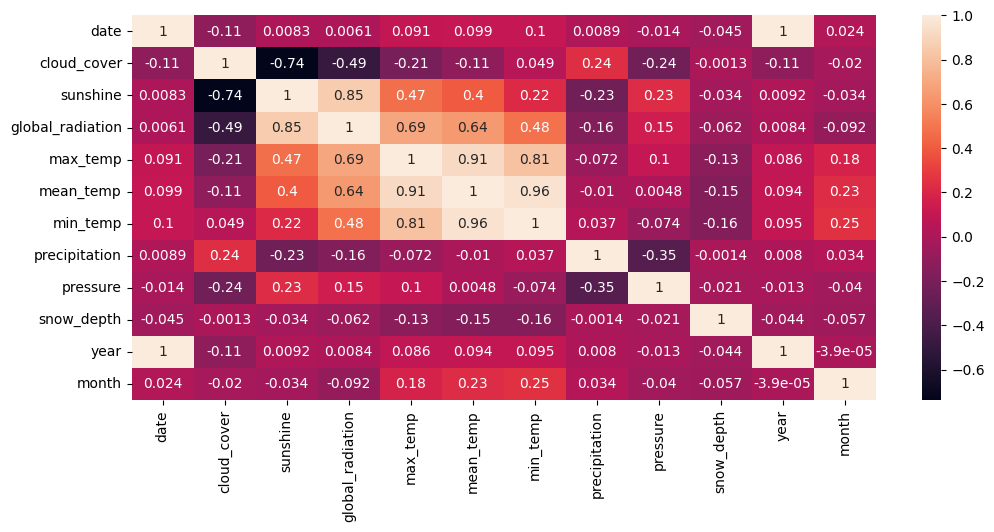

In [93]:
plt.figure(figsize=(12, 5))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [94]:
relevant_columns= ['month', 'cloud_cover', 'sunshine', 'global_radiation', 'snow_depth', 'mean_temp']
df= df[relevant_columns]

***Function To Reproduce***

In [95]:
def preprocess_df(df, feature_selection, target_var):
    df = df.dropna(subset=[target_var])
    X = df[feature_selection]    
    y = df[target_var]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
    
    imputer = SimpleImputer(strategy="mean")
    X_train = imputer.fit_transform(X_train)
    X_test  = imputer.transform(X_test)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

feature_selection = ['month', 'cloud_cover', 'sunshine', 'global_radiation', 'snow_depth']
target_var = 'mean_temp'
X_train, X_test, y_train, y_test = preprocess_df(df, feature_selection, target_var)

MLflow allows to run different experiments, log the experiments, and also save the model with the best result

***Machine Learning Experiment***

In [105]:
mlflow.set_experiment('Experiment 1')

with mlflow.start_run():
    model = DecisionTreeRegressor()
    model.fit(X_train, y_train)

    # Predicttest set
    y_pred = model.predict(X_test)

    # Calculate RMSE
    rmse = root_mean_squared_error(y_test, y_pred)

    # Log hyperparameters and metrics
    mlflow.set_experiment_tag("model", "decision tree")
    mlflow.log_metric("rmse", rmse)

    # Save the model
    mlflow.sklearn.log_model(model, "model")
    
mlflow.search_runs(experiment_names=["Experiment 1"])

2024/03/15 18:27:11 INFO mlflow.tracking.fluent: Experiment with name 'Experiment 1' does not exist. Creating a new experiment.


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.rmse,tags.mlflow.user,tags.mlflow.runName,tags.mlflow.source.type,tags.mlflow.source.name,tags.mlflow.log-model.history
0,91077f8dc67b43deb4074cafc1ddba03,696125646073435942,FINISHED,file:///C:/Users/yarde/mlruns/6961256460734359...,2024-03-15 16:27:11.061000+00:00,2024-03-15 16:27:14.251000+00:00,3.679424,yarde,stylish-mole-74,LOCAL,C:\Users\yarde\AppData\Local\Programs\Python\P...,"[{""run_id"": ""91077f8dc67b43deb4074cafc1ddba03""..."


In [106]:
##delete experiment:
# experiment = mlflow.get_experiment_by_name('Experiment 1')
# if experiment:
    # mlflow.delete_experiment(experiment.experiment_id)
# else:
    # print("Experiment 'Experiment 1' not found.")

## see all experiments:
# all_runs = mlflow.search_runs(search_all_experiments=True)
# print(all_runs)

***Predict The Temperature***

In [112]:
EXPERIMENT_NAME= 'Regression 1'
EXPERIMENT_ID = mlflow.create_experiment(EXPERIMENT_NAME)

for idx, depth in enumerate([1,2,5,10,20]):
    parameters= {'max_depth':depth, 'random_state':1}
    RUN_NAME= f"fun_{idx}"

    with mlflow.start_run(experiment_id=EXPERIMENT_ID, run_name=RUN_NAME):
        dreg=DecisionTreeRegressor(**parameters).fit(X_train, y_train)
        rfreg=RandomForestRegressor(**parameters).fit(X_train, y_train)

        dreg_pred = dreg.predict(X_test)
        rfreg_pred = rfreg.predict(X_test)

        dreg_r2 = r2_score(y_test, dreg_pred)
        rfreg_r2 = r2_score(y_test, rfreg_pred)

        mlflow.log_param("max_depth", depth)
        
        mlflow.log_metric("dreg_r2", dreg_r2)
        mlflow.log_metric("rfreg_r2", rfreg_r2)

In [113]:
mlflow.search_runs(experiment_names=[EXPERIMENT_NAME])

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.rfreg_r2,metrics.dreg_r2,params.max_depth,tags.mlflow.source.type,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.runName
0,9a91fc337b9e4269bc11ff8de4473e4d,252425098357140426,FINISHED,file:///C:/Users/yarde/mlruns/2524250983571404...,2024-03-15 16:44:51.145000+00:00,2024-03-15 16:44:53.187000+00:00,0.740943,0.609961,20,LOCAL,yarde,C:\Users\yarde\AppData\Local\Programs\Python\P...,fun_4
1,d034450847ad4525b560432c36860f25,252425098357140426,FINISHED,file:///C:/Users/yarde/mlruns/2524250983571404...,2024-03-15 16:44:50.021000+00:00,2024-03-15 16:44:51.141000+00:00,0.768281,0.741046,10,LOCAL,yarde,C:\Users\yarde\AppData\Local\Programs\Python\P...,fun_3
2,284f267f579d44ca9cba772c7c4aa229,252425098357140426,FINISHED,file:///C:/Users/yarde/mlruns/2524250983571404...,2024-03-15 16:44:49.290000+00:00,2024-03-15 16:44:50.007000+00:00,0.742707,0.731995,5,LOCAL,yarde,C:\Users\yarde\AppData\Local\Programs\Python\P...,fun_2
3,750ff6f2394d405499b7218e3308d465,252425098357140426,FINISHED,file:///C:/Users/yarde/mlruns/2524250983571404...,2024-03-15 16:44:48.924000+00:00,2024-03-15 16:44:49.290000+00:00,0.554477,0.535798,2,LOCAL,yarde,C:\Users\yarde\AppData\Local\Programs\Python\P...,fun_1
4,919170a06a7e4335977d0c1fab83b63f,252425098357140426,FINISHED,file:///C:/Users/yarde/mlruns/2524250983571404...,2024-03-15 16:44:48.570000+00:00,2024-03-15 16:44:48.924000+00:00,0.332191,0.316893,1,LOCAL,yarde,C:\Users\yarde\AppData\Local\Programs\Python\P...,fun_0
